In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from IPython.display import display

from dlp.dataset import Dataset
from dlp.visualizer import Visualizer, SemanticVisualizer

from spot_detector.detector import LocalDetector
from route_planner.graph import WaypointsGraph
from route_planner.a_star import AStarPlanner

## Load Dataset

In [2]:
# Load dataset
ds = Dataset()

home_path = str(Path.home())
ds.load(home_path + '/dlp-dataset/data/DJI_0012')

## Plot the local view

In [3]:
# Instantiate the visualizer object
smt_vis = SemanticVisualizer(ds, steps=10)

scene = ds.get('scene', ds.list_scenes()[0])
frame = ds.get_future_frames(scene['first_frame'],timesteps=50)[-1]
# frame = ds.get('frame', scene['first_frame'])
img_frame = smt_vis.plot_frame(frame['frame_token'])

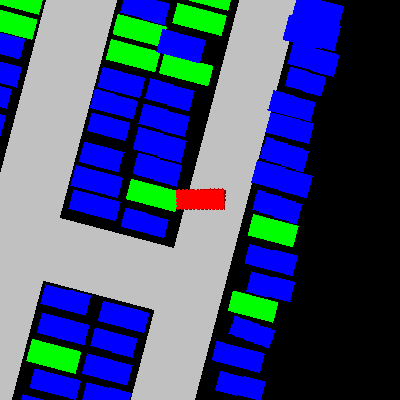

In [4]:
img = smt_vis.inst_centric(img_frame, frame['instances'][0])
display(img)

## Spot Detector

In [5]:
spot_color_rgb = (0, 255, 0)

detector = LocalDetector(spot_color_rgb)

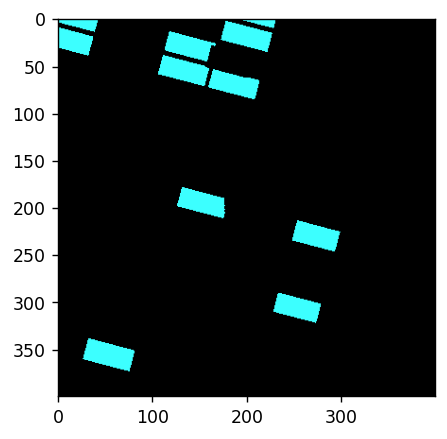

In [6]:
res = detector.spots_mask(img)
plt.imshow(res)

In [7]:
boxes = detector.detect(img)
result_img = res.copy()

for rect in boxes:
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(result_img,[box],0,(255,0,0),2)

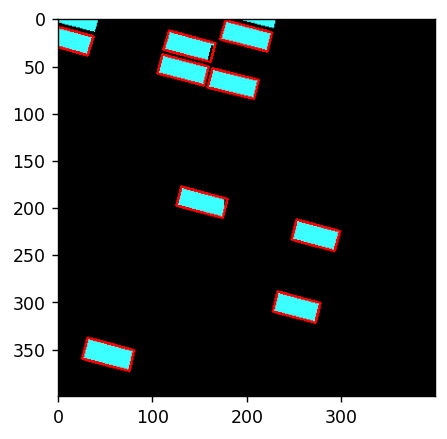

In [8]:
plt.imshow(result_img)

In [9]:
waypoints_graph = WaypointsGraph()

waypoints_graph.setup_with_vis(smt_vis)

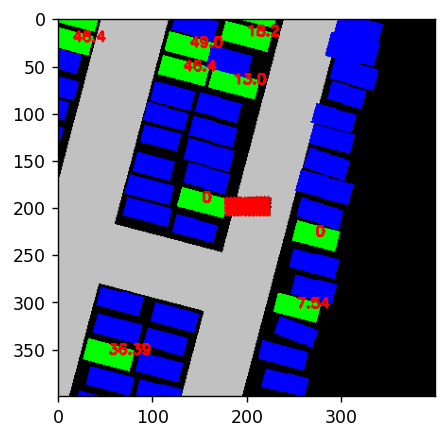

In [10]:
result_img_cost = np.array(img)

instance = ds.get('instance', frame['instances'][0])
current_state = np.array([instance['coords'][0], instance['coords'][1], instance['heading'], instance['speed']])

current_vertex_idx = waypoints_graph.search(current_state[:2])

spot_loc_cost = []

for rect in boxes:
    center_pixel = np.array(rect[0])
    center_ground = smt_vis.local_pixel_to_global_ground(current_state, center_pixel)
    spot_vertex_idx = waypoints_graph.search(center_ground)

    if spot_vertex_idx == current_vertex_idx:
        cost_to_spot = 0
    else:
        planner = AStarPlanner(waypoints_graph.vertices[current_vertex_idx], waypoints_graph.vertices[spot_vertex_idx])
        cost_to_spot = planner.solve().path_cost()

    spot_loc_cost.append((center_ground, cost_to_spot))

    cv2.putText(result_img_cost, str(np.around(cost_to_spot, 2)), center_pixel.astype('int32'), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)

plt.imshow(result_img_cost)